# Генератор (болталка)

In [ ]:
!pip install -q transformers[torch]

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

model_name_or_path = "sberbank-ai/rugpt3medium_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3medium_based_on_gpt2")
model = GPT2LMHeadModel.from_pretrained(model_name_or_path)

In [ ]:
def respond_to_dialog(texts):
    prefix = '\nx:'
    for i, t in enumerate(texts):
        prefix += t
        prefix += '\nx:' if i % 2 == 1 else '\ny:'
    tokens = tokenizer(prefix, return_tensors='pt')
    tokens = {k: v.to(model.device) for k, v in tokens.items()}
    end_token_id = tokenizer.encode('\n')[0]
    size = tokens['input_ids'].shape[1]
    output = model.generate(
        **tokens,
        eos_token_id=end_token_id,
        do_sample=True,
        max_length=size+128,
        repetition_penalty=3.2,
        temperature=1,
        num_beams=3,
        length_penalty=0.01,
        pad_token_id=end_token_id
    )
    decoded = tokenizer.decode(output[0])
    result = decoded[len(prefix):]
    return result.strip()

# "Бот-лекарь"

In [ ]:
! unzip /content/drive/MyDrive/NLPКурсовая/medical_qa_ru_data.zip

Archive:  /content/drive/MyDrive/NLPКурсовая/medical_qa_ru_data.zip
  inflating: medical_qa_ru_data.csv  


In [ ]:
#! pip install razdel pymorphy2

In [ ]:
#!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2023-09-19 09:54:05--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.100, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75fcdqadl1p2crfno2e6ulmph7ar5ljl/1695117225000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=b6dba9ab-cdb3-45bf-8c09-66585a5408ba [following]
--2023-09-19 09:54:06--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75fcdqadl1p2crfno2e6ulmph7ar5ljl/1695117225000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=b6dba9ab-cdb3-45bf-8c09-66585a5408ba
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 74.125.199.132, 2607:

In [ ]:
import numpy as np
import pandas as pd
import re
#from corus import load_rudrec
from tqdm import tqdm_notebook
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling,  TFAutoModelForSequenceClassification, Trainer, TrainingArguments
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
#from razdel import tokenize
#import pymorphy2
import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# stopword_ru = stopwords.words('russian')
# with open('stopwords.txt') as f:
#     additional_stopwords = [w.strip() for w in f.readlines() if w]

# stopword_ru += additional_stopwords

In [ ]:
data = pd.read_csv('medical_qa_ru_data.csv')
data.head(5)

,date,categ,theme,desc,ans,spec10
0,"8 Октября 2017, 11:55",Оториноларингология,Применение Ларипронта.,"Ларипронт 20 талеток,через каждые 2-3 часа.Оче...",Что вы им лечите? Длительность приема Ларипрон...,Отоларинголог
1,"20 Февраля 2019, 13:24",Акушерство,Беременность,"Здравствуйте, я на 7-8 неделе беременности. С ...","Здравствуйте, это может быть признаком раннего...",NaN
2,"17 Марта 2015, 18:31",Другое,гинекология,Здравствуйте месячные должны придти 23 марта в...,Выполните исследование хгч,NaN
3,"13 Января 2019, 19:38",Терапия,Занятия спорта после сдачи крови,"Завтра иду с утра сдавать кровь ТТГ, Т4СВ, Кал...","Можно.;\nЗдравствуйте , да, попейте сладкого ч...",Терапевт
4,"28 Ноября 2017, 21:58",Другое,Таблетки,Мне прописали пить Аллохол. Врач написала пить...,Препарат принимается после еды. Уточните это ...,NaN


In [ ]:
# data.ans = data.ans.apply(lambda x: re.split(r';\n', str(x))[0])
# data.ans[0]

In [ ]:
data = data[['desc', 'ans']]
data.dropna(subset=['desc', 'ans'], inplace=True)
data

,desc,ans
0,"Ларипронт 20 талеток,через каждые 2-3 часа.Оче...",Что вы им лечите? Длительность приема Ларипрон...
1,"Здравствуйте, я на 7-8 неделе беременности. С ...","Здравствуйте, это может быть признаком раннего..."
2,Здравствуйте месячные должны придти 23 марта в...,Выполните исследование хгч
3,"Завтра иду с утра сдавать кровь ТТГ, Т4СВ, Кал...","Можно.;\nЗдравствуйте , да, попейте сладкого ч..."
4,Мне прописали пить Аллохол. Врач написала пить...,Препарат принимается после еды. Уточните это ...
...,...,...
190328,"Не курю и не пью. Веду здоровый образ жизни, м...",В первую очередь вам необходимо обследовать пе...
190329,"Здравствуйте, очень прошу консультации. В лево...",Начинать следует с терапевтических методов. Ес...
190330,"Здравствуйте! В глаз отлетел кусок пластмассы,...","Ромашка есть дома, альбуцид;\nМожно промыть лю..."
190332,"Здравствуйте, три дня назад порезала палец бу...","Здравствуйте , пока обработать Хлоргексидином ..."


In [ ]:
def clean_text(text):
    res = str(text).strip()
    res = re.sub(r';\n', " ", res)
    res = re.sub(r"[^А-Яа-я0-9]", " ", res)
    # tokens = list(tokenize(res))
    # words = [_.text for _ in tokens]
    # words_without_stopwords = [i for i in words if not i in stopword_ru]
    return res#' '.join(words_without_stopwords)

# cache = {}
# morph = pymorphy2.MorphAnalyzer()

# def lemmatization(text):

#     if not isinstance(text, str):
#         text = str(text)


#     tokens = list(tokenize(text))
#     words = [_.text for _ in tokens]

#     words_lem = []
#     for w in words:
#         if w[0] == '-':
#             w = w[1:]
#         if len(w) > 1:
#             if w in cache:
#                 words_lem.append(cache[w])
#             else:
#                 temp_cach = cache[w] = morph.parse(w)[0].normal_form
#                 words_lem.append(temp_cach)

#     words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]

#     return ' '.join(words_lem_without_stopwords)

# def preproc_text(text):
#   temp = clean_text(text)
#   res = lemmatization(temp)
#   return res


def build_data(data_q, data_ans):
    data = []
    for idx, texts in enumerate(data_q):
        question = texts
        answer = data_ans.iloc[idx]
        res = '\nx:' + question + '\ny:' + answer
        data.append(res)
    return data

In [ ]:
data['desc'] = data['desc'].progress_apply(lambda x: clean_text(x))

100%|██████████| 171337/171337 [00:04<00:00, 34874.22it/s]


In [ ]:
data['ans'] = data['ans'].progress_apply(lambda x: clean_text(x))

100%|██████████| 171337/171337 [00:06<00:00, 26486.25it/s]


In [ ]:
text_train, text_valid, y_train, y_valid = train_test_split(data['desc'],
                                                            data['ans'],
                                                            test_size=.2,
                                                            random_state=42)

In [ ]:
import torch
device = torch.device("cuda")

In [ ]:
model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer_1 = AutoTokenizer.from_pretrained(model_name)
model_1 = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_data = build_data(text_train, y_train)
test_data = build_data(text_valid, y_valid)

In [ ]:
tokenizer_1.pad_token = tokenizer_1.eos_token

In [ ]:
train_encodings = tokenizer_1(train_data, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer_1(test_data, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [ ]:
class QAMedicalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = QAMedicalDataset(train_encodings)
test_dataset = QAMedicalDataset(test_encodings)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer_1, mlm=False)

In [ ]:
training_args = TrainingArguments(
    output_dir="./qa_medical", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )

In [ ]:
trainer = Trainer(
    model=model_1,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

In [ ]:
tokenize_1.save_pretrained(path + 'tokenizer_qa_medical_gen')
model_1.save_pretrained(path + 'model_qa_medical_gen')

In [ ]:
tokenizer_1 = AutoTokenizer.from_pretrained(path + 'tokenizer_qa_medical_gen')
model_1 = AutoModelForCausalLM.from_pretrained(path + 'model_qa_medical_gen')

In [ ]:
def respond_to_dialog_med(texts):
    prefix = '\nx:'
    for i, t in enumerate(texts):
        prefix += t
        prefix += '\nx:' if i % 2 == 1 else '\ny:'
    tokens = tokenizer_1(prefix, return_tensors='pt')
    tokens = {k: v.to(model_1.device) for k, v in tokens.items()}
    end_token_id = tokenizer_1.encode('\n')[0]
    size = tokens['input_ids'].shape[1]
    output = model_1.generate(
        **tokens,
        eos_token_id=end_token_id,
        do_sample=True,
        max_length=size+128,
        repetition_penalty=3.2,
        temperature=1,
        num_beams=3,
        length_penalty=0.01,
        pad_token_id=end_token_id
    )
    decoded = tokenizer_1.decode(output[0])
    result = decoded[len(prefix):]
    return result.strip()

# Bot

In [ ]:
!pip install pytelegrambotapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.13.0-py3-none-any.whl size=214529 sha256=bb1d8b7488af2912f0cece7b713c627564de6086d296c7b5ccb405b09793c17d
  Stored in directory: /root/.cache/pip/wheels/f7/1a/3b/41e1ce64625e3f11567085dc79043d9fa573a2cc39f9938556
Successfully built pytelegrambotapi


In [ ]:
history_dialog = []

def babbler(text):
    global history_dialog

    history_dialog.append(text)
    history_dialog.append(respond_to_dialog(history_dialog[-10:]))
    if len(history_dialog) > 10: history_dialog = history_dialog[-10:]

    return history_dialog[-1]

In [ ]:
history = []
def q_a_med(text):
    history.append(text)
    history.append(respond_to_dialog_med(history[-10:]))
    if len(history) > 10: history = history[-10:]

    return history[-1]

In [ ]:
import telebot
from telebot import types

# Создаем экземпляр бота
bot = telebot.TeleBot("6661137834:AAF4UpCDuiidmiQAjMbV_DeRH4Y-ILZHYs0")

# Функция, обрабатывающая команду /start
@bot.message_handler(commands=['start'])
def start(message):
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    btn1 = types.KeyboardButton("Привет")
    markup.add(btn1)
    bot.send_message(message.chat.id, f"👋 Привет {message.from_user.first_name}! Я твой бот-помощник!", reply_markup=markup)

Flag = 0
@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    global Flag
    # Если нажали на одну из кнопок
    if call.data.lower() == 'можем поболтать':
        Flag = 1
        bot.send_message(call.message.chat.id, 'О чём хотите поговорить?')
    if call.data.lower() == 'бот-лекарь':
        Flag = 2
        bot.send_message(call.message.chat.id, 'Что Вас беспокоит? ')


# Получение сообщений от пользователя
@bot.message_handler(content_types=["text"])
def handle_text(message):
    global Flag

    if message.text.lower() == 'привет': Flag = 0


    if Flag == 0:# or message.text == 'Назад':
        # Готовим кнопки
        keyboard = types.InlineKeyboardMarkup()
        # И добавляем кнопку на экран
        key_oven = types.InlineKeyboardButton(text='Можем поболтать', callback_data='можем поболтать')
        # И добавляем кнопку на экран
        keyboard.add(key_oven)
        key_telec = types.InlineKeyboardButton(text='Бот-лекарь', callback_data='бот-лекарь')
        keyboard.add(key_telec)
        # Показываем все кнопки сразу и пишем сообщение о выборе
        bot.send_message(message.chat.id, text='Сделайте, пожалуйста, выбор.', reply_markup=keyboard)

    elif Flag == 1:
        bot.send_message(message.chat.id, babbler(message.text))

    elif Flag == 2:
        bot.send_message(message.chat.id, q_a_med(message.text))


# Запускаем бота
bot.polling(none_stop=True, interval=0)

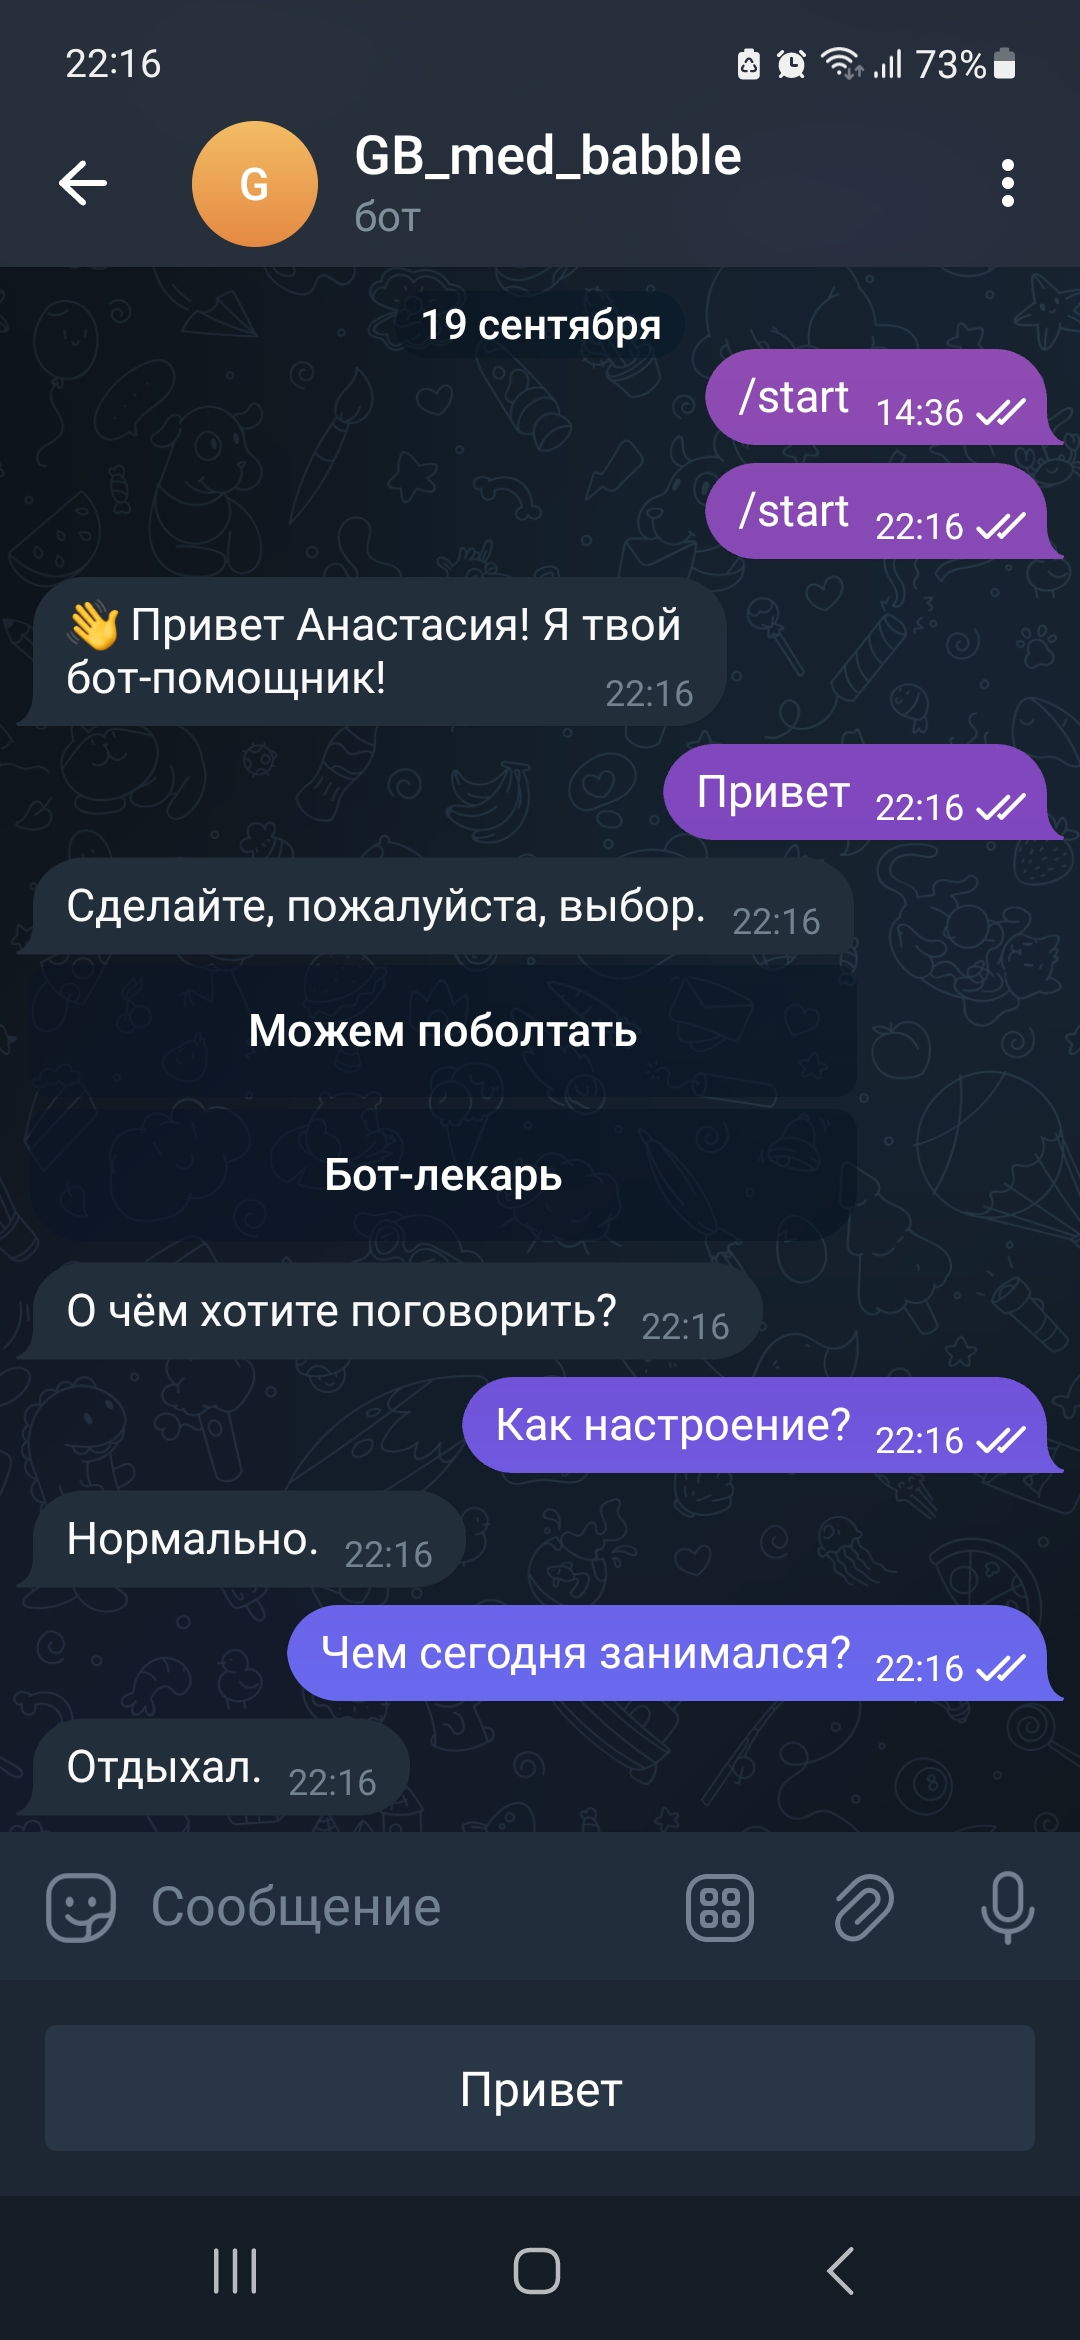

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# загружаем изображение с диска в переменную
# надо написать адрес к изображению на вашем диске
img1 = cv2.imread("/content/drive/MyDrive/NLPКурсовая/Screenshot_20230919_221657_Telegram.jpg")

# выводим изображение на экран
cv2_imshow(img1)